In [2]:
from transformers import pipeline
from datasets import load_dataset, DatasetDict
import torch
import nltk
import evaluate
import pandas as pd
import numpy as np
from tqdm import tqdm
import multiprocessing

nltk.download('punkt')

/home/haskari/miniconda3/envs/acl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/haskari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import torch
import nltk
import evaluate
import multiprocessing
nltk.download('punkt')
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import pandas as pd
from nltk import sent_tokenize
import math, re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from datasets import load_dataset, DatasetDict, load_from_disk
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import Trainer, TrainingArguments, pipeline
import argparse
import pickle as pkl
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/haskari/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Gold Standard**


In [ ]:
# data = load_dataset("argilla/news-summary")
# article_key = 'text'
# summary_key = 'prediction'
# data = DatasetDict({
#     'train': data['test'],
#     'test': data['train']})

In [ ]:
  # data = load_dataset('reddit_tifu', 'long')
  # article_key = 'documents'
  # summary_key = 'tldr'
  # # 80% train, 20% test + validation
  # train_testvalid = data['train'].train_test_split(test_size=0.2, seed=42)
  # # Split the 20% test + valid in half test, half valid
  # test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)
  # # gather everyone if you want to have a single DatasetDict
  # data = DatasetDict({
  #     'train': train_testvalid['train'],
  #     'test': test_valid['test'],
  #     'validation': test_valid['train']})

In [4]:
data = load_dataset('cnn_dailymail','3.0.0')
#data = load_dataset("xsum")

In [ ]:
# data = load_dataset('xsum', split='test[97%:100%]')
# #data = load_dataset("xsum")
# article_key = 'document'
# summary_key = 'summary'

In [ ]:

# data = load_dataset("argilla/news-summary")
# article_key = 'text'
# summary_key = 'prediction'
# data = DatasetDict({
#     'train': data['test'],
#     'test': data['train']})

In [ ]:
# data = load_dataset('reddit_tifu', 'long')
# article_key = 'documents'
# summary_key = 'tldr'
#     # 80% train, 20% test + validation
# train_testvalid = data['train'].train_test_split(test_size=0.2, seed=42)
# # Split the 20% test + valid in half test, half valid
# test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)
# # gather everyone if you want to have a single DatasetDict
# data = DatasetDict({
#     'train': train_testvalid['train'],
#     'test': test_valid['test'],
#     'validation': test_valid['train']})

In [ ]:
# len(data['train'])

In [ ]:
# len(data['test'])

In [ ]:
# data['prediction']

In [5]:
data = data['test']
data

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})

In [6]:
with open('data/cnn_new_new.pkl', 'rb') as f:
    summaries=pkl.load(f)

In [7]:
bad_index=[]
for idx,sum in enumerate(summaries):
    if not sum:
        bad_index.append(idx)

In [8]:
bad_index[0:5]

[64, 83, 111, 120, 167]

In [9]:
data=data.select(i for i in range(len(data)) 
                 if i not in set(bad_index))

Parameter 'indices'=<generator object <genexpr> at 0x7ff744d8c120> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [10]:
data

Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 10766
})

In [ ]:
# for items in data:
#   # print(items['prediction'][0])
#   break

In [11]:
def generate_n_segments(a, n=10): #NEW
  k, m = divmod(len(a), n)
  return list((i*k+min(i, m),(i+1)*k+min(i+1, m)) for i in range(n))

  # return list((i*k+min(i, m),(i+1)*k+min(i+1, m)) for i in range(n))

In [ ]:
# ip = ['I am a person.', 'I am not a dog.', 'I am not a cat.', 'I am a person.', 'Listen to me roar.', 'Bark bark.']
# op = generate_n_segments(ip, n=2)
# op

In [ ]:
# op = generate_n_segments(ip, n=4)
# op

In [12]:
def tokenize(example):
    example["original_article"] = example['article']
    example["article"] = nltk.sent_tokenize(example["article"])
    example["highlights"] = nltk.sent_tokenize(example["highlights"]) #[0]['text'])
    example['segment_idxs'] = generate_n_segments(example["article"]) #NEW
    return example

data = data.map(tokenize, num_proc=multiprocessing.cpu_count())

Map (num_proc=48): 100%|██████████| 10766/10766 [00:00<00:00, 11714.36 examples/s]


In [13]:
data['segment_idxs'][0]

[[0, 3],
 [3, 6],
 [6, 9],
 [9, 12],
 [12, 15],
 [15, 18],
 [18, 21],
 [21, 23],
 [23, 25],
 [25, 27]]

In [ ]:
# hist=[]
# for art in data['article']:
#   hist.append(len(art))

# plt.hist(hist)
# plt.show()
# print(np.max(hist))

In [ ]:
# len(data['train']['segment_idxs'][0])

In [ ]:
# from rouge_score import rouge_scorer
# scorer = rouge_scorer.RougeScorer(['rouge2'],use_stemmer=True)

In [14]:
def get_overlap_scores(sentences, document):
    corpus = sentences + document
    vect = TfidfVectorizer()
    tfidf = vect.fit_transform(corpus)
    similarities = (tfidf * tfidf.T).toarray()

    return similarities[:len(sentences), len(sentences):]


def get_summary_indices_modified(article, summary, top_k=1, tolerance=0.1): #NEW

    scores = get_overlap_scores(summary, article)

    idx = scores.argmax(axis=1)
    false_idxs = np.where(scores.max(axis=1) == 0)
    idx = np.delete(idx, false_idxs)
    scores = np.delete(scores, false_idxs, axis=0)

    if top_k > 1 and len(article) > 1:
        search_idx = np.where((scores.max(axis=1) < 1-tolerance))
        biggest_idx = np.argpartition(scores[search_idx], -top_k)[:, -top_k:]
        unique_idx = np.concatenate((idx, biggest_idx.flatten()))
        unique_idx = np.unique(unique_idx)
    else:
        unique_idx = np.unique(idx)

    unique_idx.sort()
    return unique_idx

In [ ]:
# data['highlights'][0]

In [ ]:
# get_summary_indices_modified(data['article'][0],list(data['highlights'][0]+list(data['highlights'][2])))

In [15]:
def summary_to_segments(example, n=10): #NEW
  article = example['article']
  summary = example['highlights']
  segment_idxs = example['segment_idxs']

  try:
    mapped_idxs = get_summary_indices_modified(article, summary)
  except Exception as e:
    print(e)
    example['mapping']=np.random.randint(0,2,10)
    print(np.random.randint(0,2,10))
    return example

  mapped_idxs=mapped_idxs.tolist()
  bin_counts = [0]*n
  # print(mapped_idxs)

  for mapped_idx in mapped_idxs:
    for i,segment_idx in enumerate(segment_idxs):
      if mapped_idx >= segment_idx[0] and mapped_idx < segment_idx[1]:
        bin_counts[i] += 1
        break


  example['mapping'] = bin_counts
  return example


data = data.map(summary_to_segments, num_proc=multiprocessing.cpu_count())

Map (num_proc=48): 100%|██████████| 10766/10766 [00:01<00:00, 5856.10 examples/s]


In [16]:
 randnums= np.random.randint(0,2,10)
 randnums

array([1, 1, 1, 0, 1, 0, 1, 1, 0, 1])

In [17]:
data['mapping']

[[1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
 [0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 2, 0, 0, 1, 1, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
 [3, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
 [2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
 [1, 0, 1, 0, 1, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1,

In [ ]:
# def map_summary_to_bin(data):

#     summary = data['highlights']
#     bined_text = data['bined_article']

#     print(summary)
#     print(bined_text)

#     #Output a list of length M,
#     no_bins = len(bined_text)

#     #compare the gs_i with each sentence and then take average of bin
#     l = [0]*no_bins
#     summary_scores = [0]*len(summary)
#     summary_bins = [-1]*len(summary)
#     for ind_sum, sent_gs in enumerate(summary):

#         max_rs = 0
#         max_bin = -1
#         for ind_bin, curr_bin in enumerate(bined_text):
#             if len(curr_bin) == 0:
#                 continue
#             rs = 0 #initialise rs as 0
#             for sent in curr_bin:
#                 rs += scorer.score(sent_gs, sent)['rouge2'][2] #2 is fmeasure
#             rs /= len(curr_bin) #averaging out
#             if rs > max_rs:
#                 max_rs = rs
#                 max_bin = ind_bin #set the current bin as index
#                 summary_scores[ind_sum] = max_rs
#                 summary_bins[ind_sum] = max_bin
#         l[max_bin] += 1

#     #list max scores, list bins, for each summary
#     data['r_scores'] = summary_scores
#     data['bins'] = summary_bins
#     data['mapping'] = l
#     return data

# data = data.map(map_summary_to_bin, num_proc=multiprocessing.cpu_count())

In [18]:
data

Dataset({
    features: ['article', 'highlights', 'id', 'original_article', 'segment_idxs', 'mapping'],
    num_rows: 10766
})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


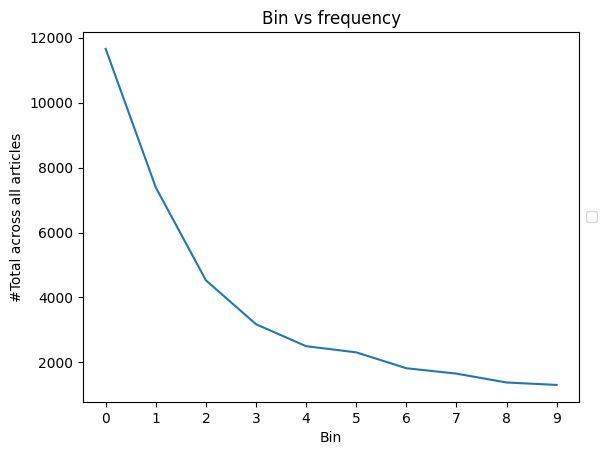

In [19]:
import numpy as np
import matplotlib.pyplot as plt

plt.xlabel("Bin")
plt.ylabel("#Total across all articles")
plt.title("Bin vs frequency")


cumm_list = [0]*10

#for ind, da in enumerate(data['test']): #NEW
for ind, da in enumerate(data): #NEW
    y = da['mapping']
#     print(y)
    cumm_list = [a+b for a,b in zip(cumm_list, y)]

x = [j for j in range(10)]
plt.plot(x, cumm_list)
plt.xticks(x)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# def calculate_length(example):
#     #Calculates lengths in number of sentences
#     example["article_length"] = len(example['article'])
#     example["highlights_length"] = len(example["highlights"])

#     return example

# data = data.map(calculate_length,num_proc=multiprocessing.cpu_count())
# data

In [ ]:
# def get_overlap_scores(sentences, document):
#     corpus = sentences + document
#     vect = TfidfVectorizer()
#     tfidf = vect.fit_transform(corpus)
#     similarities = (tfidf * tfidf.T).toarray()

#     return similarities[:len(sentences), len(sentences):]


# def get_summary_indices(example, top_k=1, tolerance=0.1):
#     article = example['article']
#     summary = example['highlights']

#     scores = get_overlap_scores(summary, article)

#     idx = scores.argmax(axis=1)
#     false_idxs = np.where(scores.max(axis=1) == 0)
#     idx = np.delete(idx, false_idxs)
#     scores = np.delete(scores, false_idxs, axis=0)

#     if top_k > 1 and len(article) > 1:
#         search_idx = np.where((scores.max(axis=1) < 1-tolerance))
#         biggest_idx = np.argpartition(scores[search_idx], -top_k)[:, -top_k:]
#         unique_idx = np.concatenate((idx, biggest_idx.flatten()))
#         unique_idx = np.unique(unique_idx)
#     else:
#         unique_idx = np.unique(idx)

#     unique_idx.sort()
#     example['unique_idx'] = unique_idx
#     return example

In [ ]:
# data = data.map(get_summary_indices)
# data


In [20]:
article_sentences = []
for article in data['article']:
  for sentence in article:
    article_sentences.append(sentence)

highlight_sentences = []
for highlight in data['highlights']:
  for sentence in highlight:
    highlight_sentences.append(sentence)

len(article_sentences),len(highlight_sentences)

(358354, 40603)

In [ ]:
# #Save to Disk and copy to drive

# data.save_to_disk('cnn_dailymail_augmented')

# **Pegasus**

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# summ_tokenizer = AutoTokenizer.from_pretrained('google/pegasus-cnn_dailymail')
# summ_model = AutoModelForSeq2SeqLM.from_pretrained('google/pegasus-cnn_dailymail').to('cuda')

In [ ]:
# def get_summary_indices_pp(example, top_k=1, tolerance=0.1):
#     article = example['article']
#     summary = example['model_summaries']

#     scores = get_overlap_scores(summary, article)

#     idx = scores.argmax(axis=1)
#     false_idxs = np.where(scores.max(axis=1) == 0)
#     idx = np.delete(idx, false_idxs)
#     scores = np.delete(scores, false_idxs, axis=0)

#     if top_k > 1 and len(article) > 1:
#         search_idx = np.where((scores.max(axis=1) < 1-tolerance))
#         biggest_idx = np.argpartition(scores[search_idx], -top_k)[:, -top_k:]
#         unique_idx = np.concatenate((idx, biggest_idx.flatten()))
#         unique_idx = np.unique(unique_idx)
#     else:
#         unique_idx = np.unique(idx)

#     unique_idx.sort()
#     example['pp_idx'] = unique_idx
#     return example

In [21]:
multiprocessing.cpu_count()

48

In [22]:
type(data)

datasets.arrow_dataset.Dataset

In [ ]:
# data_subsection=data.select(range(500))

In [ ]:
# from transformers import Pipeline
# pipe = pipeline("summarization",model = "google/pegasus-cnn_dailymail", tokenizer = "google/pegasus-cnn_dailymail",device=0)

In [ ]:
# data

In [ ]:
# import time
# t = time.time()
# model_outputs = pipe(data['original_article'],clean_up_tokenization_spaces=True,truncation=True,batch_size = 4)
# print(time.time()-t)

In [23]:
model_outputs=[x for x in summaries if x]

In [27]:
# [i['summary_text'] for i in model_outputs]

In [24]:
len(data),len(model_outputs)

(10766, 10766)

In [25]:
model_outputs[20]

['Louis Jordan was rescued by a container ship after being lost at sea for 66 days on his sailboat.',
 'He survived by collecting rainwater and catching fish that were attracted to his laundry.',
 'Jordan was in surprisingly good condition and knew almost exactly what day it was upon his rescue.']

In [26]:
data = data.add_column("model_summaries", model_outputs)

In [40]:
# def tokenize(example):
#     example["model_summaries"] = nltk.sent_tokenize(example["model_summaries"]['summary_text'].replace('<n>', ' '))
#     return example

# data = data.map(tokenize, num_proc=multiprocessing.cpu_count())
# scorer = rouge_scorer.RougeScorer(['rouge2'],use_stemmer=True)


# def map_summary_to_bin2(data):
#     """
#     compares each sentence in summary with average rouge score of each bin and
#     selects the bin with the max average rouge score.

#     Adds:
#      data['r_scores'] -> A list containing max binned rouge score
#      e.g.: [0.15, 0.23, 0.13, ......] first sentence in summary has the highest
#       mapped score of 0.15, second has 0.23, etc.

#      data['bins'] -> list which maps sentence in the summary to the bin
#      e.g: 0, 3, 2, 1, ... => first sentence maps to bin 0,
#      second maps to bin 3, third maps to bin 2, fourth maps to bin 1, and
#      there are no more sentences in summary.

#      data['mapping'] -> list of size no. of bins (10)  that tracks
#      e.g: 4, 1, 0, 0, 0, 0, 0, 0, 0...  imlpies that 4 sentences in summary map to bin 0
#      and 1 maps to bin 1.
#     """
#     summary = data['model_summaries']
#     bined_text = data['bined_article']

#     #Output a list of length M,
#     no_bins = len(bined_text)

#     #compare the gs_i with each sentence and then take average of bin
#     l = [0]*no_bins
#     summary_scores = [0]*len(summary)
#     summary_bins = [-1]*len(summary)
#     for ind_sum, sent_gs in enumerate(summary):

#         max_rs = 0
#         max_bin = -1
#         for ind_bin, curr_bin in enumerate(bined_text):
#             if len(curr_bin) == 0:
#                 continue
#             rs = 0 #initialise rs as 0
#             for sent in curr_bin:
#                 rs += scorer.score(sent_gs, sent)['rouge2'][2] #2 is fmeasure
#             rs /= len(curr_bin) #averaging out
#             if rs > max_rs:
#                 max_rs = rs
#                 max_bin = ind_bin #set the current bin as index
#                 summary_scores[ind_sum] = max_rs
#                 summary_bins[ind_sum] = max_bin
#         l[max_bin] += 1

#     #list max scores, list bins, for each summary
#     data['r_scores_gen'] = summary_scores
#     data['bins_gen'] = summary_bins
#     data['mapping_gen'] = l
#     return data

Map (num_proc=48):   0%|          | 0/10766 [00:01<?, ? examples/s]


TypeError: list indices must be integers or slices, not str

In [27]:
def summary_to_segments_gen(example, n=10): #NEW
  article = example['article']
  summary = example['model_summaries']
  segment_idxs = example['segment_idxs']

  mapped_idxs = get_summary_indices_modified(article, summary)

  bin_counts = [0]*n

  for mapped_idx in mapped_idxs:
    for i,segment_idx in enumerate(segment_idxs):
      if mapped_idx >= segment_idx[0] and mapped_idx < segment_idx[1]:
        bin_counts[i] += 1
        break

  example['mapping_gen'] = bin_counts
  return example


data = data.map(summary_to_segments_gen, num_proc=multiprocessing.cpu_count())

Map (num_proc=48): 100%|██████████| 10766/10766 [00:02<00:00, 4003.95 examples/s]


In [ ]:
# data_subsection = data_subsection.map(map_summary_to_bin2, num_proc=multiprocessing.cpu_count())

In [ ]:
# data_subsection=data_subsection.map(get_summary_indices_pp, num_proc=multiprocessing.cpu_count())

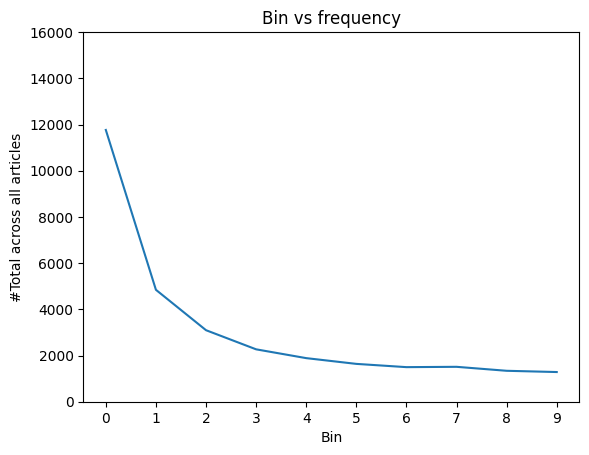

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.xlabel("Bin")
plt.ylabel("#Total across all articles")
plt.title("Bin vs frequency")


cumm_list = [0]*10

for ind, da in enumerate(data):
    y = da['mapping_gen']
#     print(y)
    cumm_list = [a+b for a,b in zip(cumm_list, y)]

x = [j for j in range(10)]
ax = plt.gca()
ax.set_ylim([0, 16000])
plt.plot(x, cumm_list)
plt.xticks(x)
plt.show()

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# plt.xlabel("Bin")
# plt.ylabel("#Total across all articles")
# plt.title("Bin vs frequency")


cumm_list1 = [0]*10
cumm_list2 = [0]*10

for ind, da in enumerate(data):
    y1 = da['mapping_gen']
#     print(y)
    cumm_list1 = [a+b for a,b in zip(cumm_list1, y1)]
    y2 = da['mapping']
#     print(y)
    cumm_list2 = [a+b for a,b in zip(cumm_list2, y2)]

x = [j for j in range(10)]

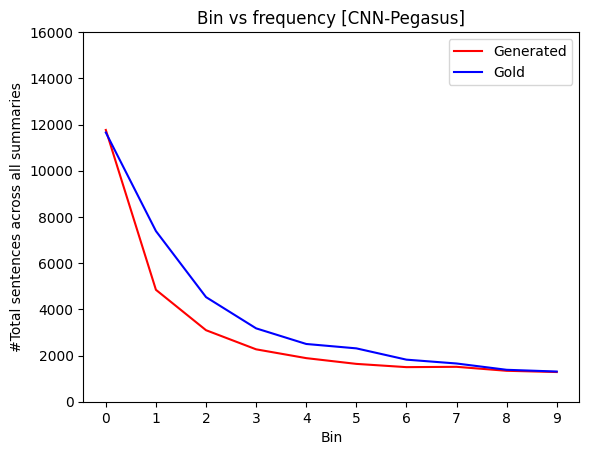

In [31]:
plt.xlabel("Bin")
plt.ylabel("#Total sentences across all summaries")
plt.title("Bin vs frequency [CNN-Pegasus]")
ax = plt.gca()
ax.set_ylim([0, 16000])
plt.plot(x, cumm_list1, label="Generated", color='red')
plt.plot(x, cumm_list2, label="Gold", color='blue')
plt.xticks(x)
plt.legend()
plt.show()

In [45]:
highlights = []
model_s = []


for j in data['highlights']:
    highlights.append(' '.join(j))

for k in data['model_summaries']:
    model_s.append(' '.join(k))

In [46]:
import evaluate

#Evaluate
rouge = evaluate.load('rouge')

print("==> Comparing generated summaries with gold summaries")
results = rouge.compute(predictions=model_s, references=highlights)
print(results)

==> Comparing generated summaries with gold summaries
{'rouge1': 0.36150084168136376, 'rouge2': 0.13504594659169686, 'rougeL': 0.23795711685873466, 'rougeLsum': 0.24126182674732768}


In [47]:
def kl_divergence(p, q):
    """
    Calculates the KL divergence between two probability distributions p and q.
    """
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [48]:
kl_divergence(np.array(cumm_list1), np.array(cumm_list2))

-5462.899501285191

In [49]:
kl_divergence(np.array(cumm_list1)/np.sum(cumm_list1), np.array(cumm_list2)/np.sum(cumm_list2))

0.016558355588629333